### How to earn effectively as a software developer?
Dataset:Stack Overflow Data-2019 Survey https://insights.stackoverflow.com/survey/2019  

Software developers has the image that doing lots of overtime work.  
However, there is some of them are having good income and also keeping there work-life balance good.
Naturally, I asked myself: Can I be one of them? Is it too late for me? What should I do for that?
With these question, I did a brief research with the 2019 Stack Overflow's annual Developer Survey.The survey includes nearly 90,000 developers answer.  


For simplicity,I look at professional developers in the top 10 apearance of countries:'United States', 'India', 'United Kingdom', 'Germany', 'Canada', 'France', 'Brazil', 'Poland', 'Australia', 'Netherlands',
'Russian Federation'.  
In addition,call the group of people who has both of good income and good work-life balance as "star-group".  
To focus on the "star-group", I extract these who think about their career 'Slightly satisfied' and 'Very satisfied' group. Moreover,to avoid the group of people who earning money by getting lots of overtime pay, I decided to look at "hourly income" instead of "annual income".  
"hourly income" = "annual income" / "work hours".  

I raised these 4 questions as below.  
1. What programming language is popular in the "star-group"?
2. What kind of database is popular in the "star-group"?
3. How old and how many years coding as professional developer are they in the "star-group"?
4. What is the key factors of having over than medium income and keeping work-life balance?

P.S.
1. I chose below columns in survey for simplicity:  
'Employment', 'Country', 'EdLevel', 'OrgSize', 'DevType', 'YearsCodePro', 'MgrWant', 'JobSeek', 'LastHireDate', 'WorkPlan','CareerSat', 'WorkLoc', 'CodeRevHrs', 'LanguageWorkedWith', 'DatabaseWorkedWith', 'OpSys', 'Age', 'Gender', 'Dependents', 'EarningPerHours'.
2. Salary converted to annual USD salaries using the exchange rate on 2019-02-01, 


Read the survey csv file to dataframe 

In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from feature_selector import FeatureSelector
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head(1)

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult


In [163]:
df.shape

(88883, 85)

Data cleaning

In [164]:
# A function to separate columns including multiple values which separated by ";"
def clean_separate_multivalues(col_list,df):
    df = df.dropna(subset=col_list, axis=0)
    new_df = df.copy()
    for column in col_list:
        new_df = new_df.set_index(new_df.columns.drop(column).to_list())
        new_df = new_df[column].str.split(';', expand=True)
        new_df = \
            (new_df.stack()
            .reset_index()
            .rename(columns={0:column})
            .loc[:, df.columns]
            )
    return new_df

In [165]:
#Only look at professional developers
df = df[df.MainBranch == 'I am a developer by profession']
#To avoid too much data, only analysis the Top 10 countries here
countries = df.Country.value_counts(ascending = False)[:11]
df = df[df['Country'].isin(countries.index)]
#Remove duplicated data
df.drop_duplicates(keep = 'first', inplace = True)
df.duplicated().sum()

0

In [166]:
#Calculate compensation per hours, assuming 12 working months and 50 working weeks.
# Drop rows with missing salary related values
df = df.dropna(subset = ['ConvertedComp','WorkWeekHrs'], axis = 0)
df['EarningPerHours'] = df['ConvertedComp']/(df['WorkWeekHrs']*50)
df = df.drop(['ConvertedComp','WorkWeekHrs'],axis =1)
#delete outliers, keep only the ones that are within +3 to -3 standard deviations
df = df[np.abs(df.EarningPerHours-df.EarningPerHours.mean()) <= (3*df.EarningPerHours.std())]

In [167]:
#Change years data type to "int"
df = df.replace('Less than 1 year',0)
df = df.replace('More than 50 years',50)
df['YearsCodePro'] = df['YearsCodePro'].fillna(0).astype(int)

In [168]:
#Take work-life balance good people only
df = df.query('CareerSat == "Very satisfied" or CareerSat == "Slightly satisfied"') 

Prepare dataframes for each questions

In [169]:
# for Q1,Q2:
#1. What programming language is popular in the "star-group"?
#2. What kind of database is popular in the "star-group"?
col_dev_lang_db =  ['DevType','LanguageWorkedWith', 'DatabaseWorkedWith', 'EarningPerHours']
df_dev_lang_db = df[col_dev_lang_db].copy()
df_dev_lang_db.drop_duplicates(keep = 'first', inplace = True)

# for Q3: 
#3. How old and how many years coding as professional developer are they in the "star-group"?
col_age = ['YearsCodePro', 'Age', 'EarningPerHours']
df_age = df[col_age].copy()
df_age.drop_duplicates(keep = 'first', inplace = True)

# for Q4:
#4. What is the key factors of having over than medium income and keeping work-life balance?
col_related = ['Employment','Country', 'EdLevel', 'OrgSize',
                     'DevType', 'YearsCodePro', 
                   'MgrWant', 'JobSeek', 'LastHireDate','WorkPlan','CareerSat',
        'WorkLoc', 'CodeRevHrs','LanguageWorkedWith', 'DatabaseWorkedWith', 'OpSys', 
                   'Age', 'Gender','Dependents','EarningPerHours']

df_related = df[col_related].copy()
df_related.drop_duplicates(keep = 'first', inplace = True)

In [170]:
df_related.shape

(25682, 20)

### Question 1. What programming language is popular in the "star-group"?

In [171]:
df_dev_lang_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25651 entries, 3 to 88325
Data columns (total 4 columns):
DevType               25479 non-null object
LanguageWorkedWith    25588 non-null object
DatabaseWorkedWith    23000 non-null object
EarningPerHours       25651 non-null float64
dtypes: float64(1), object(3)
memory usage: 1002.0+ KB


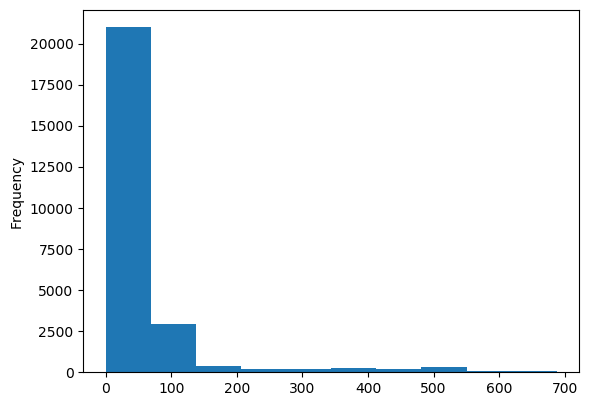

In [172]:
df_dev_lang_db.EarningPerHours.plot(kind = 'hist')

We can see most of developers get lest than 100 USD per hour.This is reasonable.  
Calculate average Earning Per Hours of each Developer type and Language type.

In [173]:
df_dev_lang_db = clean_separate_multivalues(['DevType','LanguageWorkedWith', 'DatabaseWorkedWith'],df_dev_lang_db)
df_dev_lang = df_dev_lang_db.groupby(['DevType','LanguageWorkedWith']).mean();
df_dev_lang = df_dev_lang.reset_index()
df_dev_lang.head(1)

,DevType,LanguageWorkedWith,EarningPerHours
0,Academic researcher,Assembly,53.376072


To see what group of people have good "Earning Per Hours"

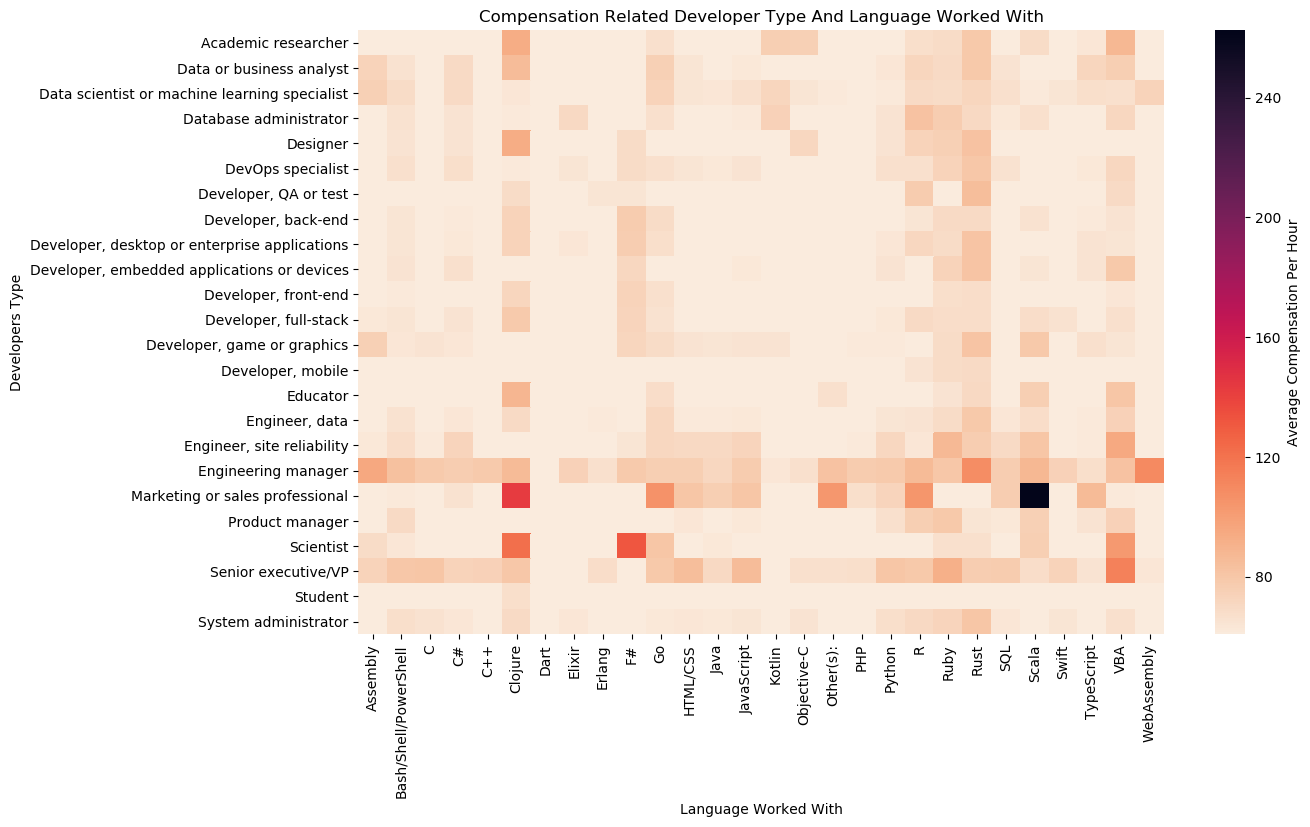

In [174]:
df_dev_lang = df_dev_lang.pivot(index = 'DevType',
                               columns = 'LanguageWorkedWith',
                               values = 'EarningPerHours')
plt.figure(figsize=(13, 8)) 
plt.title('Compensation Related Developer Type And Language Worked With')
ax = sns.heatmap(df_dev_lang,cmap = 'rocket_r',vmin = vmin_top,cbar = True )
ax.collections[0].colorbar.set_label("Average Compensation Per Hour")
plt.xlabel('Language Worked With')
plt.ylabel('Developers Type')
plt.show()

The group of  good "Earning Per Hours" developer type are "Engineering manager", "Marketing or sales professional","Scientist","Senior executive/VP".  
The group of  good "Earning Per Hours" using languages are "Clojure","F#","Go","R","Ruby","Rust","VBA"."Scala".  
Outstanding group of good "Earning Per Hours"  is "Marketing or sales professional" who use the language "Scala".


### Question2. What kind of database is popular in the "star-group"?

In [175]:
df_dev_db = df_dev_lang_db.groupby(['DevType','DatabaseWorkedWith']).mean();
df_dev_db = df_dev_db.reset_index()
df_dev_db.head(1)

,DevType,DatabaseWorkedWith,EarningPerHours
0,Academic researcher,Cassandra,100.51755


To see what group of people have good "Earning Per Hours"

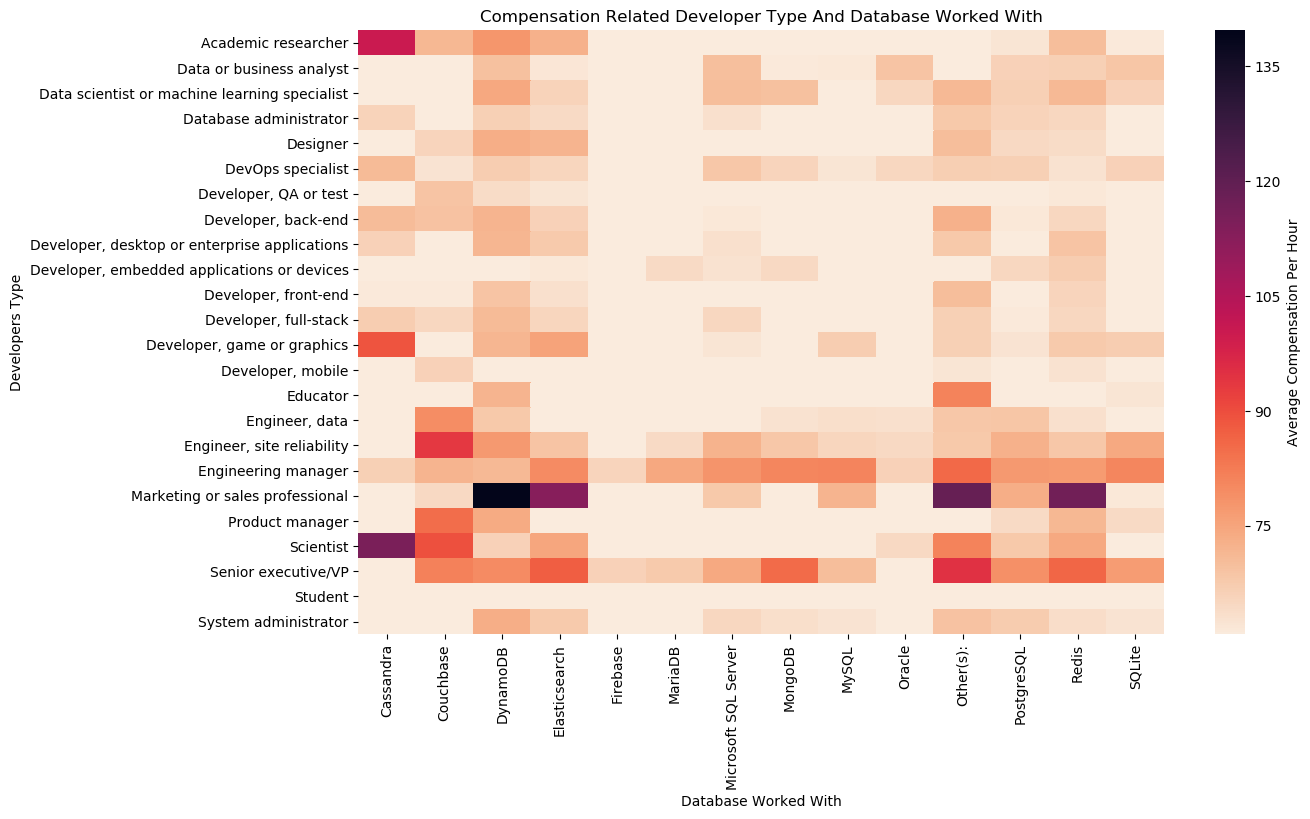

In [176]:
df_dev_db = df_dev_db.pivot(index = 'DevType',
                               columns = 'DatabaseWorkedWith',
                               values = 'EarningPerHours')
plt.figure(figsize=(13, 8)) 
plt.title('Compensation Related Developer Type And Database Worked With')
ax = sns.heatmap(df_dev_db,cmap = 'rocket_r',vmin = vmin_top,cbar = True )
ax.collections[0].colorbar.set_label("Average Compensation Per Hour")
plt.xlabel('Database Worked With')
plt.ylabel('Developers Type')
plt.show()

The group of  good "Earning Per Hours" developer type are "Engineering manager", "Marketing or sales professional","Engineer,site reliability","Scientist","Senior executive/VP".  
The group of good "Earning Per Hours" using languages are: "Cassandra","Couchbase","DynamoDB","Elasticsearch","PostgreSQL","Redis".  
Outstanding group of good "Earning Per Hours" is "Marketing or sales professional" who use the language "DynamoDB".

### Question3. How old and how many years coding as professional developer are they in the "star-group"?

In [177]:
df_age = df_age.groupby(['YearsCodePro','Age']).mean();
df_age = df_age.reset_index()
df_age.head(5)

,YearsCodePro,Age,EarningPerHours
0,0,15.0,21.916667
1,0,16.0,18.156145
2,0,17.0,9.478022
3,0,18.0,12.133982
4,0,19.0,35.273753


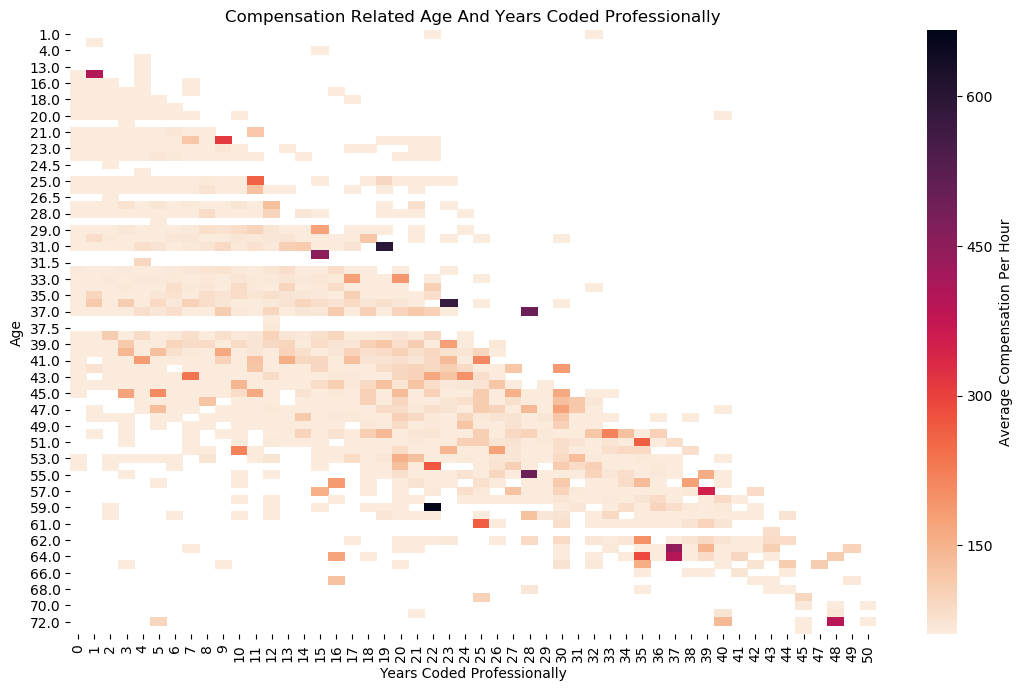

In [178]:
df_age = df_age.pivot(index = 'Age',
                      columns = 'YearsCodePro',
                      values = 'EarningPerHours'
                     )
plt.figure(figsize=(13, 8)) 
ax = sns.heatmap(df_age,cmap = 'rocket_r',vmin = vmin_top,cbar = True )
plt.title('Compensation Related Age And Years Coded Professionally')
plt.xlabel('Years Coded Professionally')
ax.collections[0].colorbar.set_label("Average Compensation Per Hour")
#plt.savefig('data/dst/seaborn_heatmap_big.png')
plt.show()

In [179]:
The group of good earner are in the age around 35-55. and outstanding good earners are in 31-37 who code as profession around 20 years.
Many of begginers who has code as profession less than 5 years are in the data, and they are earning less than others.
Longer "Years Coded Professionally" get earning better.  

SyntaxError: invalid syntax (<ipython-input-179-e449a5ce593b>, line 1)

### Question4. What is the key factors of having over than medium income and keeping work-life balance?

In [180]:
df_related.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25682 entries, 3 to 88325
Data columns (total 20 columns):
Employment            25650 non-null object
Country               25682 non-null object
EdLevel               25334 non-null object
OrgSize               25306 non-null object
DevType               25510 non-null object
YearsCodePro          25682 non-null int32
MgrWant               22236 non-null object
JobSeek               25682 non-null object
LastHireDate          25671 non-null object
WorkPlan              25224 non-null object
CareerSat             25682 non-null object
WorkLoc               25547 non-null object
CodeRevHrs            20565 non-null float64
LanguageWorkedWith    25619 non-null object
DatabaseWorkedWith    23026 non-null object
OpSys                 25553 non-null object
Age                   24751 non-null float64
Gender                25258 non-null object
Dependents            25141 non-null object
EarningPerHours       25682 non-null float64
dtypes: f

In [181]:
num_vars = df_related.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
#Because I have enough data to analysis,I choose to drop these null data instead of fill it.
    df_related.dropna(subset = [col], inplace=True)

In [182]:
df_related.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19870 entries, 12 to 88325
Data columns (total 20 columns):
Employment            19849 non-null object
Country               19870 non-null object
EdLevel               19630 non-null object
OrgSize               19626 non-null object
DevType               19760 non-null object
YearsCodePro          19870 non-null int32
MgrWant               17137 non-null object
JobSeek               19870 non-null object
LastHireDate          19863 non-null object
WorkPlan              19526 non-null object
CareerSat             19870 non-null object
WorkLoc               19774 non-null object
CodeRevHrs            19870 non-null float64
LanguageWorkedWith    19828 non-null object
DatabaseWorkedWith    17876 non-null object
OpSys                 19779 non-null object
Age                   19870 non-null float64
Gender                19672 non-null object
Dependents            19564 non-null object
EarningPerHours       19870 non-null float64
dtypes: 

In [183]:
# Separate columns including multiple values which separated by ";"
col_list = ['DevType','LanguageWorkedWith', 'DatabaseWorkedWith']
new_df = clean_separate_multivalues(col_list,df_related)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109001 entries, 0 to 1109000
Data columns (total 20 columns):
Employment            1109001 non-null object
Country               1109001 non-null object
EdLevel               1091057 non-null object
OrgSize               1099214 non-null object
DevType               1109001 non-null object
YearsCodePro          1109001 non-null int64
MgrWant               823803 non-null object
JobSeek               1109001 non-null object
LastHireDate          1108351 non-null object
WorkPlan              1085308 non-null object
CareerSat             1109001 non-null object
WorkLoc               1103958 non-null object
CodeRevHrs            1109001 non-null float64
LanguageWorkedWith    1109001 non-null object
DatabaseWorkedWith    1109001 non-null object
OpSys                 1102284 non-null object
Age                   1109001 non-null float64
Gender                1092681 non-null object
Dependents            1090989 non-null object
EarningPerHou

In [184]:
# check if there is any ';'' remain and need to remove
cat_columns = new_df.select_dtypes(include=['object']).copy().columns
for column in cat_columns:
    print(column,new_df[column].str.contains(";").sum())

Employment 0
Country 0
EdLevel 0
OrgSize 0
DevType 0
MgrWant 0
JobSeek 0
LastHireDate 0
WorkPlan 270913
CareerSat 0
WorkLoc 0
LanguageWorkedWith 0
DatabaseWorkedWith 0
OpSys 0
Gender 4511
Dependents 0


Categorize 'EarningPerHours' column to 2 values: one is earning over than medium,another is lower than medium.

In [186]:
bins = [-0.5,np.percentile(new_df['EarningPerHours'],90),np.max(new_df['EarningPerHours'])]
labels=['Cat{}'.format(x) for x in range(1, len(bins))]
y = pd.cut(new_df['EarningPerHours'], bins=bins, labels=labels)


In [187]:
#Check whether there is nothing lost.
y.isna().sum()

0

Use feature_selector module to analysis factors


A way to decide which factors are important to "star-group" I use a library called feature_selector, which behind the scene utilizing a gradient boosting machine implemented in the LightGBM library.
https://lightgbm.readthedocs.io/en/latest/Quick-Start.html
A blog post on how to use this package can be found here.

https://github.com/WillKoehrsen/feature-selector
https://lightgbm.readthedocs.io/en/latest/
https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0

In [188]:
X = new_df.drop(['EarningPerHours'],axis = 1)
fs = FeatureSelector(data = X, labels = y)

In [189]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.99569	valid_0's binary_logloss: 0.0779931
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.99588	valid_0's binary_logloss: 0.0779973
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.995247	valid_0's binary_logloss: 0.0814106
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.994876	valid_0's binary_logloss: 0.0832009
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.996443	valid_0's binary_logloss: 0.0787656
Training until validation scores don't improve for 100 rounds
Did not meet early st

This method relies on a machine learning model to identify features to remove. It therefore requires a supervised learning problem with labels. 

In [190]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[10:15]
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,Age,3971.5,0.132383,0.132383
1,YearsCodePro,3872.2,0.129073,0.261457
2,CodeRevHrs,3088.0,0.102933,0.364390
3,CareerSat_Slightly satisfied,552.9,0.018430,0.382820
4,MgrWant_Not sure,538.2,0.017940,0.400760
5,"EdLevel_Bachelor’s degree (BA, BS, B.Eng., etc.)",536.1,0.017870,0.418630
6,OrgSize_20 to 99 employees,505.1,0.016837,0.435467
7,LastHireDate_Less than a year ago,502.6,0.016753,0.452220
8,OpSys_MacOS,501.6,0.016720,0.468940
9,Country_United States,498.6,0.016620,0.485560


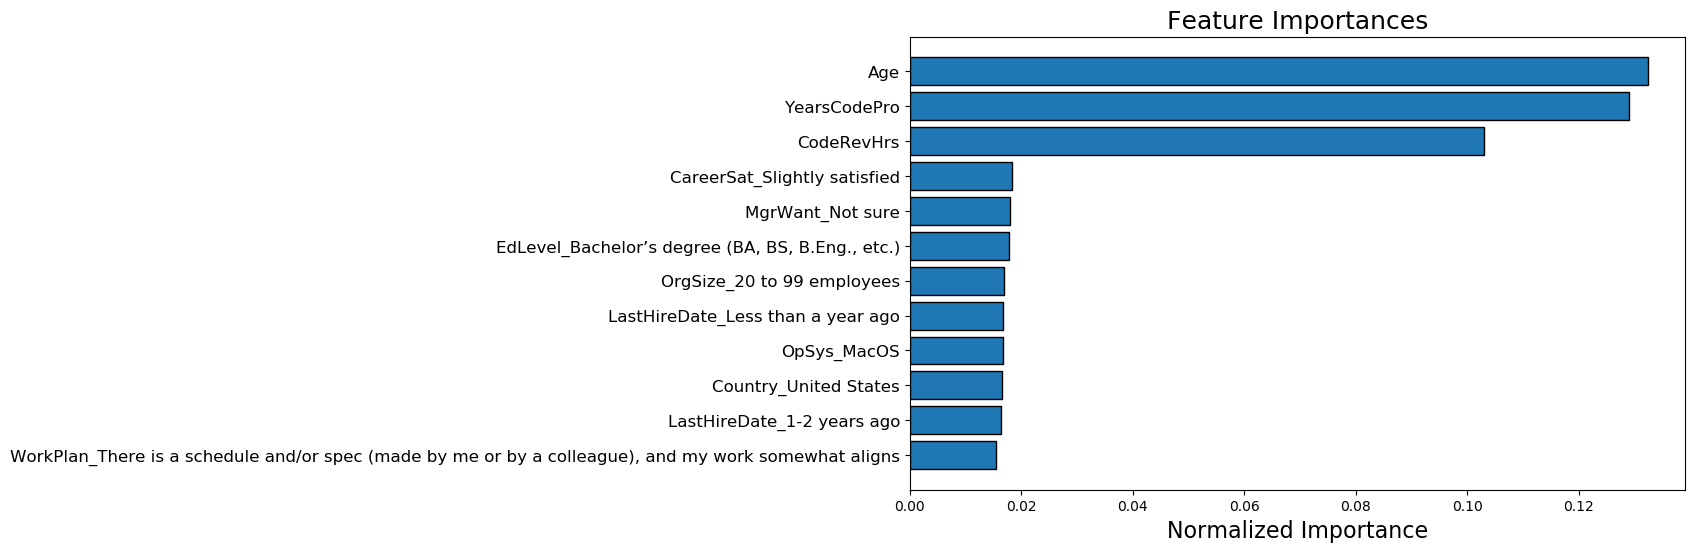

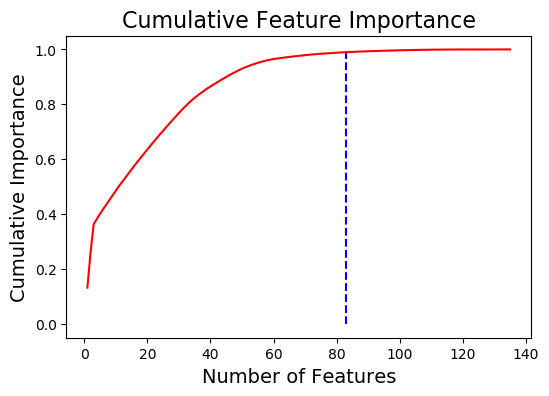

83 features required for 0.99 of cumulative importance


In [191]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

The result shows that "Age" and "Years code as profession" is very important to get a good hourly income.
The code review hours occupy the third places, indicating that longer time with code review are related to more hourly income. Then from the fourth factors like "slightly satisfied in career", "not sure to be a manager","education level of bachelor’s degree" might have subtle influences on hourly income, but not very strong.  
Refer to above,I can simply say, If one person in around age 35-55 who taking lots of time to review code,and codde as profession many years, he/she has big chance to have good hourly income and work-life balance.
